In [1]:
import sys

sys.path.insert(0, "../src")

import matplotlib.pyplot as plt
import pandas as pd

from options_hedge.vix_floor_lp import (
    PutOption,
    r_floor_adaptive,
    solve_vix_adaptive_floor_lp,
    stress_price,
    unhedged_value_at_stress,
)

plt.style.use("seaborn-v0_8-darkgrid")
%matplotlib inline

## Example 1: Basic LP Solution

**Scenario**: $1M portfolio, S&P 500 at 4500, moderate volatility (VIX = 20)

**Available options** (3-month expiry):
- 4200 strike (6.7% OTM): $12 premium
- 4350 strike (3.3% OTM): $25 premium  
- 4450 strike (1.1% OTM): $45 premium

**Question**: What's the cheapest way to ensure 85% floor protection?

In [2]:
# Portfolio parameters
V0 = 1_000_000  # $1M portfolio
S0 = 4500  # Current S&P 500 level
beta = 1.0  # Portfolio moves with index
sigma = 0.20  # 20% annualized volatility (VIX/100)
T_years = 0.25  # 3-month horizon
alpha = 0.05  # 5% tail probability (95% confidence)

# Available put options (strike, premium, expiry)
options = [
    PutOption(strike=4200, premium=12.0, expiry_years=0.25),
    PutOption(strike=4350, premium=25.0, expiry_years=0.25),
    PutOption(strike=4450, premium=45.0, expiry_years=0.25),
]

# Compute adaptive floor based on VIX = 20
vix = 20.0
r_floor = r_floor_adaptive(vix=vix, sigma=sigma, beta=beta)

print(f"Portfolio Value: ${V0:,.0f}")
print(f"S&P 500 Level: {S0}")
print(f"VIX: {vix}")
print(f"Adaptive Floor: {r_floor:.1%} (protects ${V0 * r_floor:,.0f})")
print("\nAvailable Options:")
for i, opt in enumerate(options, 1):
    otm_pct = (1 - opt.strike / S0) * 100
    print(f"  {i}. Strike {opt.strike} ({otm_pct:.1f}% OTM): ${opt.premium} premium")

Portfolio Value: $1,000,000
S&P 500 Level: 4500
VIX: 20.0
Adaptive Floor: 85.6% (protects $856,000)

Available Options:
  1. Strike 4200 (6.7% OTM): $12.0 premium
  2. Strike 4350 (3.3% OTM): $25.0 premium
  3. Strike 4450 (1.1% OTM): $45.0 premium


In [3]:
# Solve the LP
quantities, total_cost, gap_covered = solve_vix_adaptive_floor_lp(
    options=options,
    V0=V0,
    S0=S0,
    beta=beta,
    sigma=sigma,
    T_years=T_years,
    alpha=alpha,
    r_floor=r_floor,
)

# Compute stress scenario details
S_floor = stress_price(S0, sigma, T_years, alpha)
V_unhedged = unhedged_value_at_stress(V0, S0, S_floor, beta)
V_target = V0 * r_floor

print("\n" + "=" * 60)
print("LP SOLUTION")
print("=" * 60)
print("\nStress Scenario (5% tail event):")
print(f"  S&P 500 falls to: {S_floor:.0f} ({(S_floor / S0 - 1) * 100:.1f}% move)")
print(f"  Unhedged portfolio: ${V_unhedged:,.0f}")
print(f"  Target floor: ${V_target:,.0f}")
print(f"  Gap to cover: ${V_target - V_unhedged:,.0f}")

print("\nOptimal Hedge:")
for i, (opt, qty) in enumerate(zip(options, quantities), 1):
    if qty > 0.01:  # Only show non-zero positions
        cost = opt.premium * qty
        print(
            f"  Option {i} (Strike {opt.strike}): {qty:.2f} contracts @ ${opt.premium} = ${cost:,.2f}"
        )

print(f"\nTotal Premium Cost: ${total_cost:,.2f}")
print(f"As % of Portfolio: {total_cost / V0 * 100:.3f}%")
print(f"Gap Covered: ${gap_covered:,.0f}")
print(
    f"\nVerification: Unhedged ${V_unhedged:,.0f} + Hedge ${gap_covered:,.0f} = ${V_unhedged + gap_covered:,.0f}"
)
print(
    f"Target was: ${V_target:,.0f} ✓"
    if V_unhedged + gap_covered >= V_target - 0.01
    else ""
)
print("=" * 60)

Set parameter Username
Set parameter LicenseID to value 2620852
Academic license - for non-commercial use only - expires 2026-02-11

LP SOLUTION

Stress Scenario (5% tail event):
  S&P 500 falls to: 3817 (-15.2% move)
  Unhedged portfolio: $848,330
  Target floor: $856,000
  Gap to cover: $7,670

Optimal Hedge:
  Option 1 (Strike 4200): 20.05 contracts @ $12.0 = $240.61

Total Premium Cost: $240.61
As % of Portfolio: 0.024%
Gap Covered: $7,670

Verification: Unhedged $848,330 + Hedge $7,670 = $856,000
Target was: $856,000 ✓


## Example 2: VIX Sensitivity

How does optimal hedging change as VIX increases?

**Hypothesis**: Higher VIX → higher floor → more expensive hedging

In [4]:
# Test across VIX levels
vix_levels = [15, 20, 25, 30, 35, 40, 50]
results = []

for vix in vix_levels:
    sigma_test = vix / 100.0
    r_floor_test = r_floor_adaptive(vix=vix, sigma=sigma_test, beta=beta)

    _, cost, _ = solve_vix_adaptive_floor_lp(
        options=options,
        V0=V0,
        S0=S0,
        beta=beta,
        sigma=sigma_test,
        T_years=T_years,
        alpha=alpha,
        r_floor=r_floor_test,
    )

    results.append(
        {
            "VIX": vix,
            "Floor Ratio": r_floor_test,
            "Floor Value": V0 * r_floor_test,
            "Premium Cost": cost,
            "Cost %": cost / V0 * 100,
        }
    )

df_vix = pd.DataFrame(results)
print("\n" + "=" * 70)
print("VIX SENSITIVITY ANALYSIS")
print("=" * 70)
print(df_vix.to_string(index=False))
print("=" * 70)


VIX SENSITIVITY ANALYSIS
 VIX  Floor Ratio  Floor Value  Premium Cost   Cost %
  15        0.860     860000.0      0.000000 0.000000
  20        0.856     856000.0    240.613045 0.024061
  25        0.852     852000.0    846.825441 0.084683
  30        0.848     848000.0   1169.395358 0.116940
  35        0.844     844000.0   1368.161427 0.136816
  40        0.840     840000.0   1501.834151 0.150183
  50        0.820     820000.0   1549.344033 0.154934


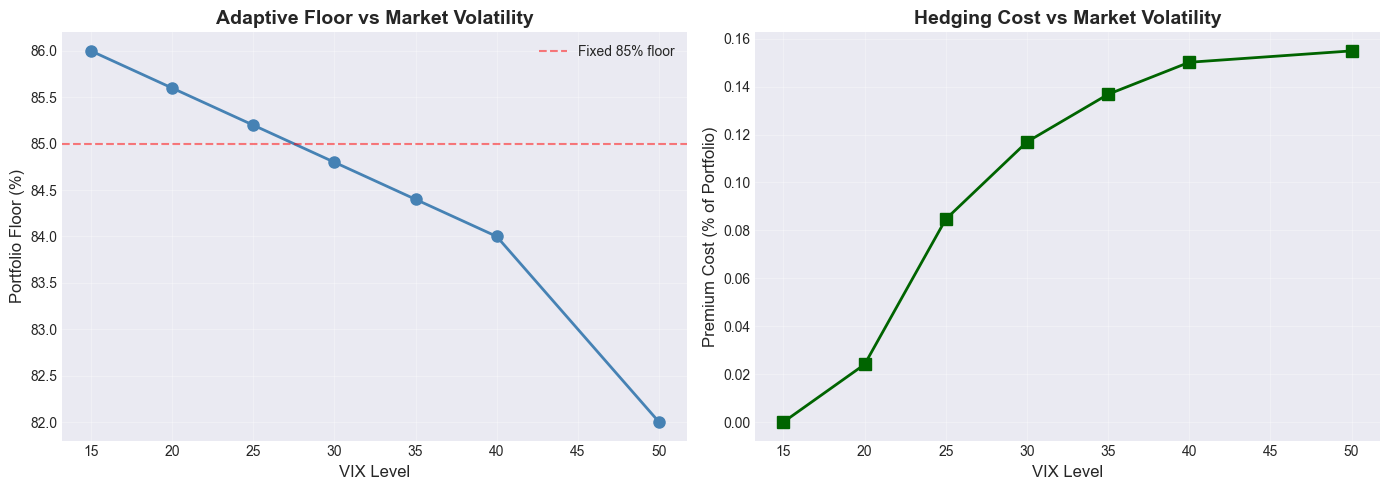


Key Insight: As VIX rises from 15 to 50:
  - Floor increases: 86.0% → 82.0%
  - Cost increases: 0.000% → 0.155%
  - Cost multiplier: infx


/var/folders/63/wv521yrn1d5_69z0psm7yvsr0000gn/T/ipykernel_34692/2575364783.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"  - Cost multiplier: {df_vix['Cost %'].iloc[-1] / df_vix['Cost %'].iloc[0]:.1f}x")


In [5]:
# Visualize VIX sensitivity
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Floor ratio vs VIX
ax1.plot(
    df_vix["VIX"],
    df_vix["Floor Ratio"] * 100,
    marker="o",
    linewidth=2,
    markersize=8,
    color="steelblue",
)
ax1.set_xlabel("VIX Level", fontsize=12)
ax1.set_ylabel("Portfolio Floor (%)", fontsize=12)
ax1.set_title("Adaptive Floor vs Market Volatility", fontsize=14, fontweight="bold")
ax1.grid(True, alpha=0.3)
ax1.axhline(y=85, color="red", linestyle="--", alpha=0.5, label="Fixed 85% floor")
ax1.legend()

# Premium cost vs VIX
ax2.plot(
    df_vix["VIX"],
    df_vix["Cost %"],
    marker="s",
    linewidth=2,
    markersize=8,
    color="darkgreen",
)
ax2.set_xlabel("VIX Level", fontsize=12)
ax2.set_ylabel("Premium Cost (% of Portfolio)", fontsize=12)
ax2.set_title("Hedging Cost vs Market Volatility", fontsize=14, fontweight="bold")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nKey Insight: As VIX rises from {vix_levels[0]} to {vix_levels[-1]}:")
print(
    f"  - Floor increases: {df_vix['Floor Ratio'].iloc[0]:.1%} → {df_vix['Floor Ratio'].iloc[-1]:.1%}"
)
print(
    f"  - Cost increases: {df_vix['Cost %'].iloc[0]:.3f}% → {df_vix['Cost %'].iloc[-1]:.3f}%"
)
print(
    f"  - Cost multiplier: {df_vix['Cost %'].iloc[-1] / df_vix['Cost %'].iloc[0]:.1f}x"
)

## Example 3: Strike Selection Trade-offs

**Question**: Should we buy many cheap OTM puts or fewer expensive ATM puts?

The LP automatically finds the optimal mix!

In [6]:
# Create broader option chain (more strikes)
strikes = [4000, 4100, 4200, 4300, 4350, 4400, 4450, 4500]
# Premiums roughly follow option pricing (further OTM = cheaper)
premiums = [5, 8, 12, 18, 25, 35, 45, 60]

options_wide = [
    PutOption(strike=k, premium=p, expiry_years=0.25) for k, p in zip(strikes, premiums)
]

# Solve with moderate VIX
vix_mid = 25
sigma_mid = vix_mid / 100.0
r_floor_mid = r_floor_adaptive(vix=vix_mid, sigma=sigma_mid, beta=beta)

quantities_wide, cost_wide, coverage_wide = solve_vix_adaptive_floor_lp(
    options=options_wide,
    V0=V0,
    S0=S0,
    beta=beta,
    sigma=sigma_mid,
    T_years=T_years,
    alpha=alpha,
    r_floor=r_floor_mid,
)

print(f"\nOptimal Option Mix (VIX = {vix_mid}):")
print("=" * 60)
for opt, qty in zip(options_wide, quantities_wide):
    if qty > 0.01:
        otm = (1 - opt.strike / S0) * 100
        cost = opt.premium * qty
        print(
            f"Strike {opt.strike} ({otm:+5.1f}% vs spot): {qty:6.2f} contracts, ${cost:8.2f}"
        )
print("=" * 60)
print(f"Total Cost: ${cost_wide:,.2f} ({cost_wide / V0 * 100:.3f}% of portfolio)")
print("=" * 60)


Optimal Option Mix (VIX = 25):
Strike 4000 (+11.1% vs spot): 112.54 contracts, $  562.68
Total Cost: $562.68 (0.056% of portfolio)


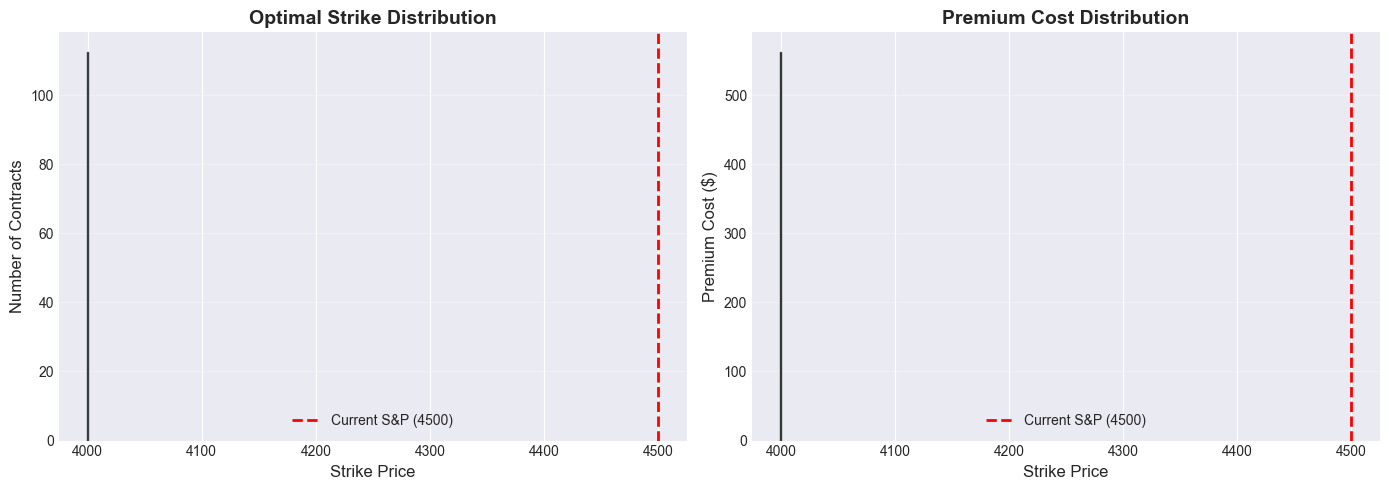

In [7]:
# Visualize strike allocation
active_strikes = [
    opt.strike for opt, qty in zip(options_wide, quantities_wide) if qty > 0.01
]
active_quantities = [qty for qty in quantities_wide if qty > 0.01]
active_costs = [
    opt.premium * qty for opt, qty in zip(options_wide, quantities_wide) if qty > 0.01
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Contract quantities by strike
ax1.bar(
    active_strikes, active_quantities, color="steelblue", alpha=0.7, edgecolor="black"
)
ax1.axvline(x=S0, color="red", linestyle="--", linewidth=2, label=f"Current S&P ({S0})")
ax1.set_xlabel("Strike Price", fontsize=12)
ax1.set_ylabel("Number of Contracts", fontsize=12)
ax1.set_title("Optimal Strike Distribution", fontsize=14, fontweight="bold")
ax1.legend()
ax1.grid(True, alpha=0.3, axis="y")

# Premium allocation by strike
ax2.bar(active_strikes, active_costs, color="darkgreen", alpha=0.7, edgecolor="black")
ax2.axvline(x=S0, color="red", linestyle="--", linewidth=2, label=f"Current S&P ({S0})")
ax2.set_xlabel("Strike Price", fontsize=12)
ax2.set_ylabel("Premium Cost ($)", fontsize=12)
ax2.set_title("Premium Cost Distribution", fontsize=14, fontweight="bold")
ax2.legend()
ax2.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

## Example 4: Beta Sensitivity

How should hedging change for aggressive vs conservative portfolios?

**Hypothesis**: Higher beta → more volatile → needs more protection OR lower floor (already risky)

In [8]:
# Test different portfolio betas
betas = [0.5, 0.75, 1.0, 1.25, 1.5]
vix_test = 20
sigma_test = vix_test / 100.0
results_beta = []

for beta_test in betas:
    r_floor_test = r_floor_adaptive(vix=vix_test, sigma=sigma_test, beta=beta_test)

    _, cost, _ = solve_vix_adaptive_floor_lp(
        options=options,
        V0=V0,
        S0=S0,
        beta=beta_test,
        sigma=sigma_test,
        T_years=T_years,
        alpha=alpha,
        r_floor=r_floor_test,
    )

    results_beta.append(
        {
            "Beta": beta_test,
            "Portfolio Type": "Conservative"
            if beta_test < 0.9
            else "Neutral"
            if beta_test < 1.1
            else "Aggressive",
            "Floor Ratio": r_floor_test,
            "Premium Cost": cost,
            "Cost %": cost / V0 * 100,
        }
    )

df_beta = pd.DataFrame(results_beta)
print(f"\nBETA SENSITIVITY (VIX = {vix_test})")
print("=" * 70)
print(df_beta.to_string(index=False))
print("=" * 70)
print("\nInsight: Higher beta portfolios get LOWER floors (adaptive to inherent risk)")
print("but may still need similar hedging costs due to larger potential losses.")


BETA SENSITIVITY (VIX = 20)
 Beta Portfolio Type  Floor Ratio  Premium Cost   Cost %
 0.50   Conservative        0.856      0.000000 0.000000
 0.75   Conservative        0.856      0.000000 0.000000
 1.00        Neutral        0.856    240.613045 0.024061
 1.25     Aggressive        0.831    528.506881 0.052851
 1.50     Aggressive        0.806    773.205512 0.077321

Insight: Higher beta portfolios get LOWER floors (adaptive to inherent risk)
but may still need similar hedging costs due to larger potential losses.


## Key Takeaways: Why Linear Programming?

### 1. **Optimality Guarantee**
The LP solver finds the **globally optimal** solution - the absolute cheapest way to achieve the floor. No heuristic guessing.

### 2. **Automatic Strike Selection**
You don't have to manually decide "should I buy 4300 or 4400 strikes?" The LP figures out the optimal mix.

### 3. **Scalability**
- 3 strikes? Solved in milliseconds.
- 100 strikes? Still solved in milliseconds.
- Real option chains have 50+ strikes - LP handles this easily.

### 4. **Adaptivity**
The VIX-adaptive floor means protection automatically adjusts to:
- Market volatility (VIX)
- Portfolio characteristics (beta)
- Investor risk tolerance (sigma reference)

### 5. **Transparency**
Unlike black-box ML models, LP gives you:
- Exact solution
- Dual variables (shadow prices)
- Constraint slack/surplus
- Interpretable results

## Real-World Considerations

**This LP is a simplification:**
- Assumes intrinsic value only (no time value)
- Uses scenario-free stress test (not full distribution)
- Ignores transaction costs (could add to $c_j$)
- No dynamic rebalancing (could extend to multi-period)

**But it demonstrates the core OR concept**: Use optimization to make better financial decisions than ad-hoc rules of thumb.

## Extensions for Future Work

1. **Multi-period LP**: Optimize hedging over rolling horizons
2. **Robust optimization**: Handle uncertain volatility estimates
3. **Integer constraints**: Require whole contracts (MILP)
4. **Transaction cost penalties**: Add fixed costs for each strike used
5. **Dynamic programming**: Optimal hedging strategy over time

## Summary

This notebook demonstrates **operations research in action**:

✅ **Formulated** a real-world financial problem as an LP  
✅ **Solved** it using Gurobi for guaranteed optimality  
✅ **Analyzed** sensitivity to key parameters (VIX, beta)  
✅ **Visualized** optimal solutions and trade-offs  

The LP is the **brain** of this project - it determines exactly how much of each option to buy to minimize costs while guaranteeing downside protection.

The simulation framework (other notebooks) shows how this plays out over time in realistic market scenarios.